# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = np.arange(1e-5, 1e-3, 2e-5)
regularization_strengths = [0.05, 0.1, 0.5, 1, 5, 10]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        model = LinearSVM()
        model.train(X_train_feats, y_train, lr, reg)
        
        train_pred = model.predict(X_train_feats)
        val_pred = model.predict(X_val_feats)
        
        train_accuracy = np.mean(train_pred == y_train)
        val_accuracy = np.mean(val_pred == y_val)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = model
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-05 reg 5.000000e-02 train accuracy: 0.197776 val accuracy: 0.201000
lr 1.000000e-05 reg 1.000000e-01 train accuracy: 0.214612 val accuracy: 0.212000
lr 1.000000e-05 reg 5.000000e-01 train accuracy: 0.210592 val accuracy: 0.214000
lr 1.000000e-05 reg 1.000000e+00 train accuracy: 0.210388 val accuracy: 0.204000
lr 1.000000e-05 reg 5.000000e+00 train accuracy: 0.233816 val accuracy: 0.256000
lr 1.000000e-05 reg 1.000000e+01 train accuracy: 0.194633 val accuracy: 0.215000
lr 3.000000e-05 reg 5.000000e-02 train accuracy: 0.327816 val accuracy: 0.317000
lr 3.000000e-05 reg 1.000000e-01 train accuracy: 0.323816 val accuracy: 0.298000
lr 3.000000e-05 reg 5.000000e-01 train accuracy: 0.328224 val accuracy: 0.354000
lr 3.000000e-05 reg 1.000000e+00 train accuracy: 0.331061 val accuracy: 0.326000
lr 3.000000e-05 reg 5.000000e+00 train accuracy: 0.338184 val accuracy: 0.352000
lr 3.000000e-05 reg 1.000000e+01 train accuracy: 0.340898 val accuracy: 0.339000
lr 5.000000e-05 reg 5.000000

In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.447


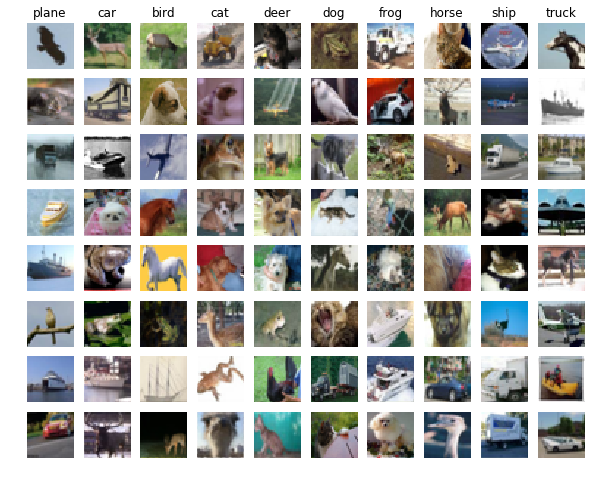

In [10]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$
It looks like an algorithms learned to distinguish animals (and birds) from things created by man (planes, ships, trucks, cars). But it fails to classify properly closed subcategories (ship <-> plane, truck <-> car, cat <-> dog etc.). 



## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [11]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [22]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = [100, 250, 500, 750]
learning_rates = [5e-2, 7.5e-2, 1e-1, 2.5e-1, 5e-1, 7.5e-1, 1]
reg_list = [1e-7, 5e-7, 1e-6, 2.5e-6, 5e-6, 7.5e-6, 1e-5]
num_classes = 10

best_net = None
best_ac = -1

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for hsize in hidden_dim:
    for lr in learning_rates:
        for reg in reg_list:
            net = TwoLayerNet(input_dim, hsize, num_classes)
            net.train(X_train_feats, y_train, X_val_feats, y_val,
                     num_iters = 2000, batch_size = 200, 
                     learning_rate = lr, learning_rate_decay=0.95,
                     reg=reg, verbose = False) 
            
            train_pred = net.predict(X_train_feats)
            val_pred = net.predict(X_val_feats)
            
            train_accuracy = np.mean(train_pred == y_train)
            val_accuracy = np.mean(val_pred == y_val)
            
            if val_accuracy > best_ac:
                best_ac = val_accuracy
                best_net = net
                
            print("lr: {:<5} reg: {:<5}".format(lr, reg), 
                  "\ttrain acc: {}".format(np.round(train_accuracy, 3)),
                  "\tval acc: {}".format(np.round(val_accuracy, 3))) 
        
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


lr: 0.05  reg: 1e-07 	train acc: 0.51 	val acc: 0.512
lr: 0.05  reg: 5e-07 	train acc: 0.513 	val acc: 0.498
lr: 0.05  reg: 1e-06 	train acc: 0.511 	val acc: 0.504
lr: 0.05  reg: 2.5e-06 	train acc: 0.513 	val acc: 0.501
lr: 0.05  reg: 5e-06 	train acc: 0.509 	val acc: 0.509
lr: 0.05  reg: 7.5e-06 	train acc: 0.511 	val acc: 0.497
lr: 0.05  reg: 1e-05 	train acc: 0.51 	val acc: 0.508
lr: 0.075 reg: 1e-07 	train acc: 0.538 	val acc: 0.523
lr: 0.075 reg: 5e-07 	train acc: 0.536 	val acc: 0.523
lr: 0.075 reg: 1e-06 	train acc: 0.537 	val acc: 0.521
lr: 0.075 reg: 2.5e-06 	train acc: 0.537 	val acc: 0.518
lr: 0.075 reg: 5e-06 	train acc: 0.537 	val acc: 0.521
lr: 0.075 reg: 7.5e-06 	train acc: 0.538 	val acc: 0.52
lr: 0.075 reg: 1e-05 	train acc: 0.539 	val acc: 0.527
lr: 0.1   reg: 1e-07 	train acc: 0.552 	val acc: 0.523
lr: 0.1   reg: 5e-07 	train acc: 0.552 	val acc: 0.546
lr: 0.1   reg: 1e-06 	train acc: 0.555 	val acc: 0.533
lr: 0.1   reg: 2.5e-06 	train acc: 0.551 	val acc: 0.527
lr:

lr: 0.05  reg: 1e-06 	train acc: 0.52 	val acc: 0.519
lr: 0.05  reg: 2.5e-06 	train acc: 0.522 	val acc: 0.511
lr: 0.05  reg: 5e-06 	train acc: 0.521 	val acc: 0.507
lr: 0.05  reg: 7.5e-06 	train acc: 0.519 	val acc: 0.509
lr: 0.05  reg: 1e-05 	train acc: 0.521 	val acc: 0.509
lr: 0.075 reg: 1e-07 	train acc: 0.542 	val acc: 0.528
lr: 0.075 reg: 5e-07 	train acc: 0.542 	val acc: 0.513
lr: 0.075 reg: 1e-06 	train acc: 0.541 	val acc: 0.516
lr: 0.075 reg: 2.5e-06 	train acc: 0.542 	val acc: 0.523
lr: 0.075 reg: 5e-06 	train acc: 0.543 	val acc: 0.521
lr: 0.075 reg: 7.5e-06 	train acc: 0.541 	val acc: 0.519
lr: 0.075 reg: 1e-05 	train acc: 0.543 	val acc: 0.536
lr: 0.1   reg: 1e-07 	train acc: 0.559 	val acc: 0.535
lr: 0.1   reg: 5e-07 	train acc: 0.56 	val acc: 0.539
lr: 0.1   reg: 1e-06 	train acc: 0.561 	val acc: 0.542
lr: 0.1   reg: 2.5e-06 	train acc: 0.561 	val acc: 0.532
lr: 0.1   reg: 5e-06 	train acc: 0.56 	val acc: 0.529
lr: 0.1   reg: 7.5e-06 	train acc: 0.559 	val acc: 0.529
l

In [23]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.561
